In [1]:
import pandas as pd
df = pd.read_csv('austrian_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:56:45.688000,RUS,63,0 days 00:01:14.401000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:32.359000,...,True,Mercedes,0 days 00:55:31.047000,2024-06-30 13:03:02.158,1,3.0,False,NaN,False,False
1,0 days 00:57:56.268000,RUS,63,0 days 00:01:10.580000,2.0,1.0,NaN,NaN,0 days 00:00:17.469000,0 days 00:00:31.731000,...,True,Mercedes,0 days 00:56:45.688000,2024-06-30 13:04:16.799,1,3.0,False,NaN,False,True
2,0 days 00:59:06.709000,RUS,63,0 days 00:01:10.441000,3.0,1.0,NaN,NaN,0 days 00:00:17.801000,0 days 00:00:31.483000,...,True,Mercedes,0 days 00:57:56.268000,2024-06-30 13:05:27.379,1,3.0,False,NaN,False,True
3,0 days 01:00:17.176000,RUS,63,0 days 00:01:10.467000,4.0,1.0,NaN,NaN,0 days 00:00:17.555000,0 days 00:00:31.631000,...,True,Mercedes,0 days 00:59:06.709000,2024-06-30 13:06:37.820,1,3.0,False,NaN,False,True
4,0 days 01:01:27.369000,RUS,63,0 days 00:01:10.193000,5.0,1.0,NaN,NaN,0 days 00:00:17.610000,0 days 00:00:31.332000,...,True,Mercedes,0 days 01:00:17.176000,2024-06-30 13:07:48.287,1,3.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,0 days 02:06:32.304000,NOR,4,0 days 00:01:09.356000,60.0,3.0,NaN,NaN,0 days 00:00:17.270000,0 days 00:00:31.434000,...,True,McLaren,0 days 02:05:22.948000,2024-06-30 14:12:54.059,1,2.0,False,NaN,False,True
1401,0 days 02:07:42.341000,NOR,4,0 days 00:01:10.037000,61.0,3.0,NaN,NaN,0 days 00:00:17.086000,0 days 00:00:32.125000,...,True,McLaren,0 days 02:06:32.304000,2024-06-30 14:14:03.415,1,2.0,False,NaN,False,True
1402,0 days 02:08:51.850000,NOR,4,0 days 00:01:09.509000,62.0,3.0,NaN,NaN,0 days 00:00:17.182000,0 days 00:00:31.527000,...,True,McLaren,0 days 02:07:42.341000,2024-06-30 14:15:13.452,1,2.0,False,NaN,False,True
1403,0 days 02:10:02.084000,NOR,4,0 days 00:01:10.234000,63.0,3.0,NaN,NaN,0 days 00:00:17.195000,0 days 00:00:32.111000,...,True,McLaren,0 days 02:08:51.850000,2024-06-30 14:16:22.961,1,2.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 71  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              2              13.0          23.333333   
1    ALO              3              12.0          17.500000   
2    BOT              2              20.0          23.333333   
3    GAS              2              21.0          23.666667   
4    HAM              2              22.0          23.666667   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          0.000000          0.171429         0.828571  
1          0.028571          0.500000         0.471429  
2          0.000000          0.271429         0.728571  
3          0.000000          0.690141         0.309859  
4          0.000000          0.549296         0.450704  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,12.0,0 days 01:10:00.156000,NaN,MEDIUM,12.0,1.0
1,ALB,13.0,NaN,0 days 01:10:21.885000,HARD,1.0,2.0
2,ALB,39.0,0 days 01:42:40.948000,NaN,HARD,27.0,2.0
3,ALB,40.0,NaN,0 days 01:43:02.616000,HARD,1.0,3.0
4,ALO,11.0,0 days 01:08:48.126000,NaN,MEDIUM,14.0,1.0
...,...,...,...,...,...,...,...
87,ZHO,1.0,NaN,0 days 00:55:41.751000,HARD,1.0,1.0
88,ZHO,28.0,0 days 01:29:38.496000,NaN,HARD,28.0,1.0
89,ZHO,29.0,NaN,0 days 01:30:01.660000,MEDIUM,1.0,2.0
90,ZHO,51.0,0 days 01:57:32.322000,NaN,MEDIUM,23.0,2.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,13.0,23.333333,0.000000,0.171429,0.828571
1,ALO,3,12.0,17.500000,0.028571,0.500000,0.471429
2,BOT,2,20.0,23.333333,0.000000,0.271429,0.728571
3,GAS,2,21.0,23.666667,0.000000,0.690141,0.309859
4,HAM,2,22.0,23.666667,0.000000,0.549296,0.450704
5,HUL,2,12.0,23.666667,0.000000,0.154930,0.845070
6,LEC,4,2.0,14.200000,0.000000,0.788732,0.211268
7,MAG,2,11.0,23.666667,0.000000,0.140845,0.859155
8,NOR,2,24.0,21.333333,0.000000,0.562500,0.437500
9,OCO,2,20.0,23.666667,0.000000,0.661972,0.338028


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,1269


In [9]:
df['Driver'].value_counts()


,count
Driver,
RUS,65
PIA,65
SAI,65
OCO,65
HAM,64
HUL,64
MAG,64
PER,64
GAS,64


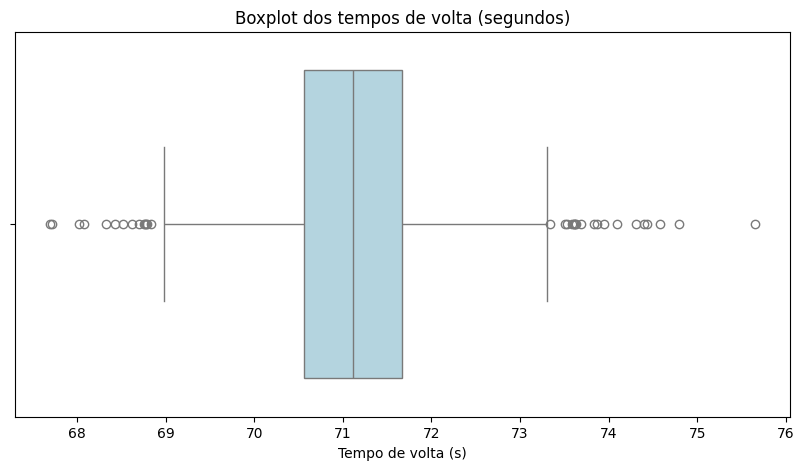

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


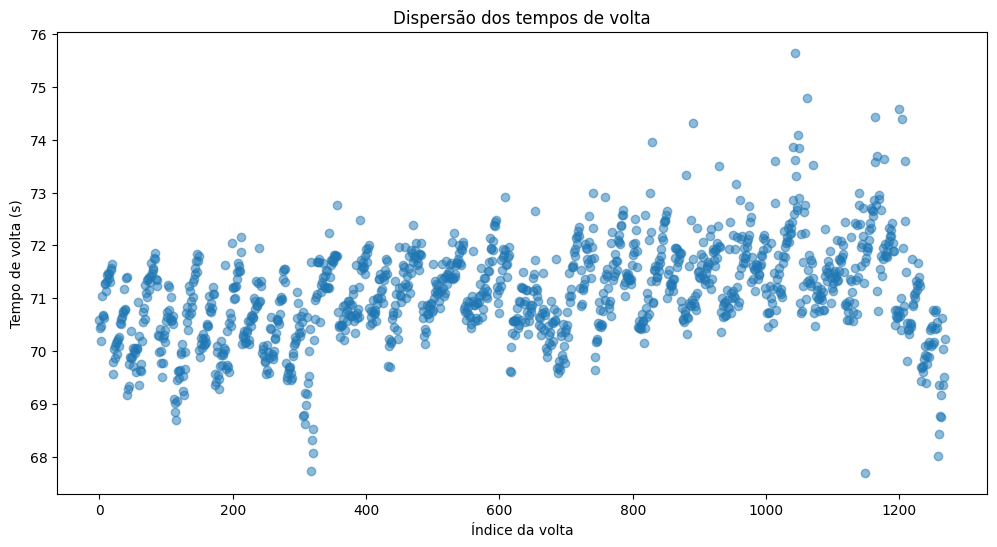

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


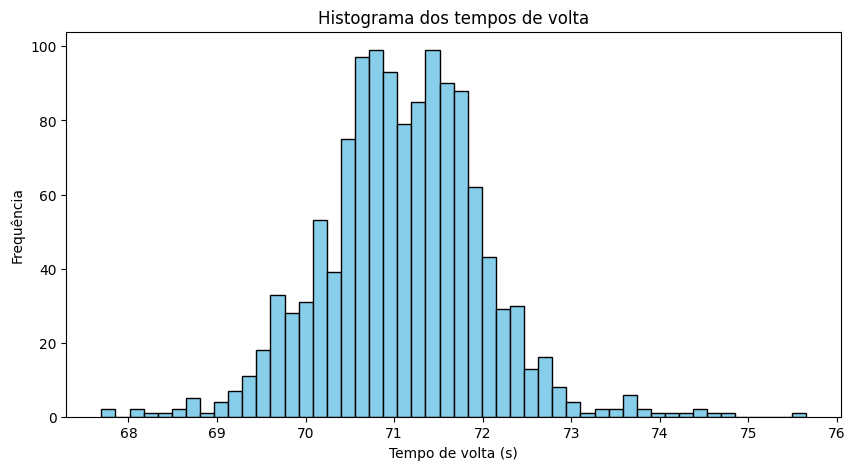

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


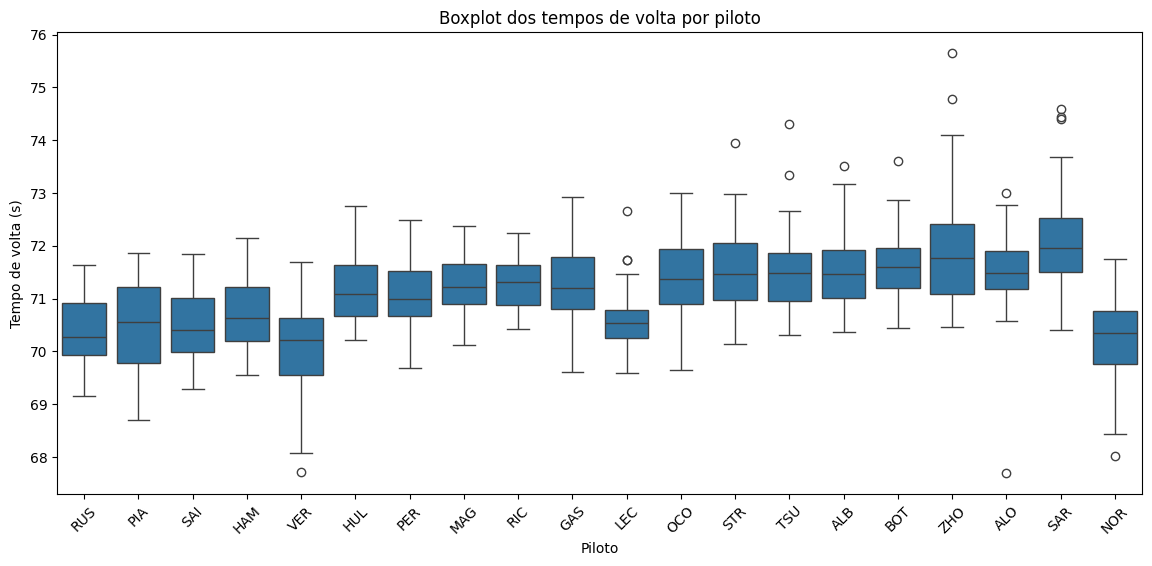

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
ALO   0 days 00:01:07.694000
VER   0 days 00:01:07.719000
NOR   0 days 00:01:08.016000
PIA   0 days 00:01:08.697000
RUS   0 days 00:01:09.164000
SAI   0 days 00:01:09.282000
HAM   0 days 00:01:09.562000
LEC   0 days 00:01:09.584000
GAS   0 days 00:01:09.609000
OCO   0 days 00:01:09.649000
PER   0 days 00:01:09.694000
MAG   0 days 00:01:10.125000
STR   0 days 00:01:10.143000
HUL   0 days 00:01:10.215000
TSU   0 days 00:01:10.318000
ALB   0 days 00:01:10.364000
SAR   0 days 00:01:10.406000
RIC   0 days 00:01:10.426000
BOT   0 days 00:01:10.449000
ZHO   0 days 00:01:10.470000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Austria'
race_date = '2024-06-30'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,64,71.508078,0.604917,70.364,73.504,71.4660,3.140,2024,Austria,2024-06-30
1,ALO,61,71.488000,0.751061,67.694,72.992,71.4850,5.298,2024,Austria,2024-06-30
2,BOT,64,71.628828,0.591093,70.449,73.607,71.6055,3.158,2024,Austria,2024-06-30
3,GAS,64,71.262391,0.684581,69.609,72.924,71.2060,3.315,2024,Austria,2024-06-30
4,HAM,64,70.697625,0.635446,69.562,72.152,70.6295,2.590,2024,Austria,2024-06-30
5,HUL,64,71.124578,0.549927,70.215,72.764,71.0975,2.549,2024,Austria,2024-06-30
6,LEC,62,70.566968,0.563359,69.584,72.652,70.5325,3.068,2024,Austria,2024-06-30
7,MAG,64,71.252734,0.489138,70.125,72.381,71.2140,2.256,2024,Austria,2024-06-30
8,NOR,58,70.237828,0.780560,68.016,71.751,70.3585,3.735,2024,Austria,2024-06-30
9,OCO,65,71.364646,0.707104,69.649,72.992,71.3750,3.343,2024,Austria,2024-06-30


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,64,71.508078,0.604917,70.364,73.504,71.4660,3.140,2024,Austria,2024-06-30,70.0,True
1,ALO,61,71.488000,0.751061,67.694,72.992,71.4850,5.298,2024,Austria,2024-06-30,70.0,True
2,BOT,64,71.628828,0.591093,70.449,73.607,71.6055,3.158,2024,Austria,2024-06-30,70.0,True
3,GAS,64,71.262391,0.684581,69.609,72.924,71.2060,3.315,2024,Austria,2024-06-30,71.0,True
4,HAM,64,70.697625,0.635446,69.562,72.152,70.6295,2.590,2024,Austria,2024-06-30,71.0,True
5,HUL,64,71.124578,0.549927,70.215,72.764,71.0975,2.549,2024,Austria,2024-06-30,71.0,True
6,LEC,62,70.566968,0.563359,69.584,72.652,70.5325,3.068,2024,Austria,2024-06-30,71.0,True
7,MAG,64,71.252734,0.489138,70.125,72.381,71.2140,2.256,2024,Austria,2024-06-30,71.0,True
8,NOR,58,70.237828,0.780560,68.016,71.751,70.3585,3.735,2024,Austria,2024-06-30,64.0,True
9,OCO,65,71.364646,0.707104,69.649,72.992,71.3750,3.343,2024,Austria,2024-06-30,71.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,13.0,23.333333,0.000000,0.171429,0.828571
1,ALO,3,12.0,17.500000,0.028571,0.500000,0.471429
2,BOT,2,20.0,23.333333,0.000000,0.271429,0.728571
3,GAS,2,21.0,23.666667,0.000000,0.690141,0.309859
4,HAM,2,22.0,23.666667,0.000000,0.549296,0.450704
5,HUL,2,12.0,23.666667,0.000000,0.154930,0.845070
6,LEC,4,2.0,14.200000,0.000000,0.788732,0.211268
7,MAG,2,11.0,23.666667,0.000000,0.140845,0.859155
8,NOR,2,24.0,21.333333,0.000000,0.562500,0.437500
9,OCO,2,20.0,23.666667,0.000000,0.661972,0.338028


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,64,71.508078,0.604917,70.364,73.504,71.4660,3.140,2024,Austria,2024-06-30,70.0,True,2,13.0,23.333333,0.000000,0.171429,0.828571
1,ALO,61,71.488000,0.751061,67.694,72.992,71.4850,5.298,2024,Austria,2024-06-30,70.0,True,3,12.0,17.500000,0.028571,0.500000,0.471429
2,BOT,64,71.628828,0.591093,70.449,73.607,71.6055,3.158,2024,Austria,2024-06-30,70.0,True,2,20.0,23.333333,0.000000,0.271429,0.728571
3,GAS,64,71.262391,0.684581,69.609,72.924,71.2060,3.315,2024,Austria,2024-06-30,71.0,True,2,21.0,23.666667,0.000000,0.690141,0.309859
4,HAM,64,70.697625,0.635446,69.562,72.152,70.6295,2.590,2024,Austria,2024-06-30,71.0,True,2,22.0,23.666667,0.000000,0.549296,0.450704
5,HUL,64,71.124578,0.549927,70.215,72.764,71.0975,2.549,2024,Austria,2024-06-30,71.0,True,2,12.0,23.666667,0.000000,0.154930,0.845070
6,LEC,62,70.566968,0.563359,69.584,72.652,70.5325,3.068,2024,Austria,2024-06-30,71.0,True,4,2.0,14.200000,0.000000,0.788732,0.211268
7,MAG,64,71.252734,0.489138,70.125,72.381,71.2140,2.256,2024,Austria,2024-06-30,71.0,True,2,11.0,23.666667,0.000000,0.140845,0.859155
8,NOR,58,70.237828,0.780560,68.016,71.751,70.3585,3.735,2024,Austria,2024-06-30,64.0,True,2,24.0,21.333333,0.000000,0.562500,0.437500
9,OCO,65,71.364646,0.707104,69.649,72.992,71.3750,3.343,2024,Austria,2024-06-30,71.0,True,2,20.0,23.666667,0.000000,0.661972,0.338028


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoAustria.csv', index=False)
